In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata, interp2d, LinearNDInterpolator

In [ ]:
def draw(file_path, damping_value: float, stiffness_value: float, label="shoulder_pan"):

    data = pd.read_csv(file_path)[
        ["Damping", "Stiffness", f"R_{label}_p", f"S_{label}_p"]
    ]

    damping = data["Damping"]
    stiffness = data["Stiffness"]

    real_position = data[f"R_{label}_p"][
        (damping == damping_value) & (stiffness == stiffness_value)
    ]
    sim_position = data[f"S_{label}_p"][
        (damping == damping_value) & (stiffness == stiffness_value)
    ]

In [93]:
def draw(file_path, label="shoulder_pan"):
    data = pd.read_csv(file_path)[
        ["Damping", "Stiffness", f"R_{label}_p", f"S_{label}_p"]
    ]

    damping = data["Damping"]
    stiffness = data["Stiffness"]

    real_position = data[f"R_{label}_p"]
    sim_position = data[f"S_{label}_p"]

    res = []

    for d in np.unique(damping):
        for s in np.unique(stiffness):
            real_pos = real_position[(damping == d) & (stiffness == s)].values

            sim_pos = sim_position[(damping == d) & (stiffness == s)].values

            pos_error = np.abs(real_pos - sim_pos)

            res.append(
                {
                    "Damping": d,
                    "Stiffness": s,
                    "Error": pos_error.mean(),
                    "Sum": pos_error.sum(),
                }
            )

    df = pd.DataFrame(res)

    # Drop rows where "Error" is greater than three times the average "Error"
    df = df[
        (df["Damping"] != df["Damping"].min())
        & (df["Stiffness"] != df["Stiffness"].min())
        & (df["Damping"] != df["Damping"].max())
        & (df["Stiffness"] != df["Stiffness"].max())
    ]

    # Fill NaN values in "Error" and "Sum" columns with their respective column averages
    df["Error"].fillna(df["Error"].mean(), inplace=True)
    df["Sum"].fillna(df["Sum"].mean(), inplace=True)

    display(df.sort_values(by="Error", ascending=False).reset_index(drop=True))

    max_error_idx = df["Error"].idxmax()
    min_error_idx = df["Error"].idxmin()

    max_row = df.loc[max_error_idx]
    min_row = df.loc[min_error_idx]

    print(
        f"Max Error: {max_row['Error']:.6f}\t at Damping={max_row['Damping']},\t Stiffness={max_row['Stiffness']}"
    )
    print(
        f"Min Error: {min_row['Error']:.6f}\t at Damping={min_row['Damping']},\t Stiffness={min_row['Stiffness']}"
    )

    x = df["Damping"].values
    y = df["Stiffness"].values
    z1 = df["Error"].values
    z2 = df["Sum"].values

    zs = [z1, z2]

    for label_type, z in zip(["Mean Error", "Sum of Error"], zs):

        # Create a linear interpolator function for the scattered data
        linear_interp = LinearNDInterpolator(list(zip(x, y)), z)

        # 보간을 위한 그리드 생성
        xi = np.linspace(np.min(x), np.max(x), 100)
        yi = np.linspace(np.min(y), np.max(y), 100)
        xi, yi = np.meshgrid(xi, yi)

        # z 값 보간 (cubic 보간)
        zi = griddata((x, y), z, (xi, yi), method="cubic")

        # 최소값 위치 찾기
        min_idx = np.unravel_index(np.nanargmin(zi), zi.shape)
        min_x, min_y, min_z = xi[min_idx], yi[min_idx], zi[min_idx]

        # 최대값 위치 찾기
        max_idx_zi = np.unravel_index(np.nanargmax(zi), zi.shape)
        max_xi, max_yi, max_zi = xi[max_idx_zi], yi[max_idx_zi], zi[max_idx_zi]

        # 시각화
        fig = plt.figure(figsize=(16, 6))

        # 1. 3D 서피스 플롯
        ax1 = fig.add_subplot(1, 2, 1, projection="3d")
        surf = ax1.plot_surface(xi, yi, zi, cmap="viridis", edgecolor="none", alpha=0.9)
        ax1.scatter(min_x, min_y, min_z, color="red", s=50, label="Minimum")
        ax1.scatter(max_xi, max_yi, max_zi, color="blue", s=50, label="Maximum")
        ax1.set_xlabel("Damping")
        ax1.set_ylabel("Stiffness")
        ax1.set_zlabel(label)
        ax1.set_title(f"{label_type}")
        ax1.legend()

        # 2. 등고선 플롯
        ax2 = fig.add_subplot(1, 2, 2)
        contour = ax2.contourf(xi, yi, zi, levels=50, cmap="viridis")
        ax2.scatter(
            min_x,
            min_y,
            color="red",
            s=50,
            label=f"Min z = {min_x:.1f}, {min_y:.1f}, {min_z:.3f}",
        )
        ax2.scatter(
            max_xi,
            max_yi,
            color="blue",
            s=50,
            label=f"Max z = {max_xi:.1f}, {max_yi:.1f}, {max_zi:.3f}",
        )
        fig.colorbar(contour, ax=ax2, label="ShoulderPan")
        ax2.set_xlabel("Damping")
        ax2.set_ylabel("Stiffness")
        ax2.set_title("Contour Plot")
        ax2.legend()

        plt.tight_layout()
        plt.show()

# 1. Shoulder Pan Joint

/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Damping    Stiffness     Error       Sum
0   88.888885   666.666687  0.070910  2.481843
1   11.111111   733.333313  0.065930  2.109763
2   11.111111  1133.333374  0.059250  2.073766
3   11.111111   666.666687  0.055465  1.941259
4   11.111111   866.666687  0.053588  1.821983
..        ...          ...       ...       ...
59  55.555557   733.333313  0.020111  0.663678
60  55.555557   666.666687  0.018905  0.642774
61  66.666664   866.666687  0.018433  0.589849
62  77.777779  1000.000000  0.018359  0.642576
63  88.888885  1000.000000  0.017539  0.596311

[64 rows x 4 columns]

Max Error: 0.070910	 at Damping=88.88888549804688,	 Stiffness=666.6666870117188
Min Error: 0.017539	 at Damping=88.88888549804688,	 Stiffness=1000.0


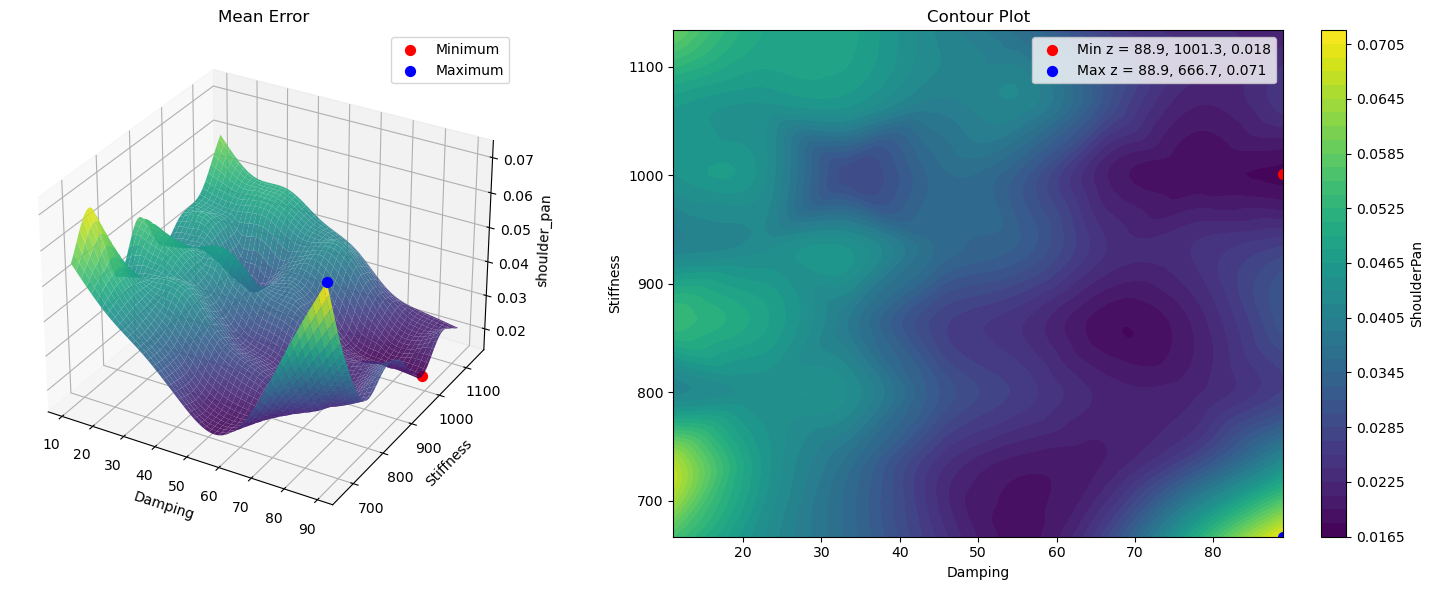

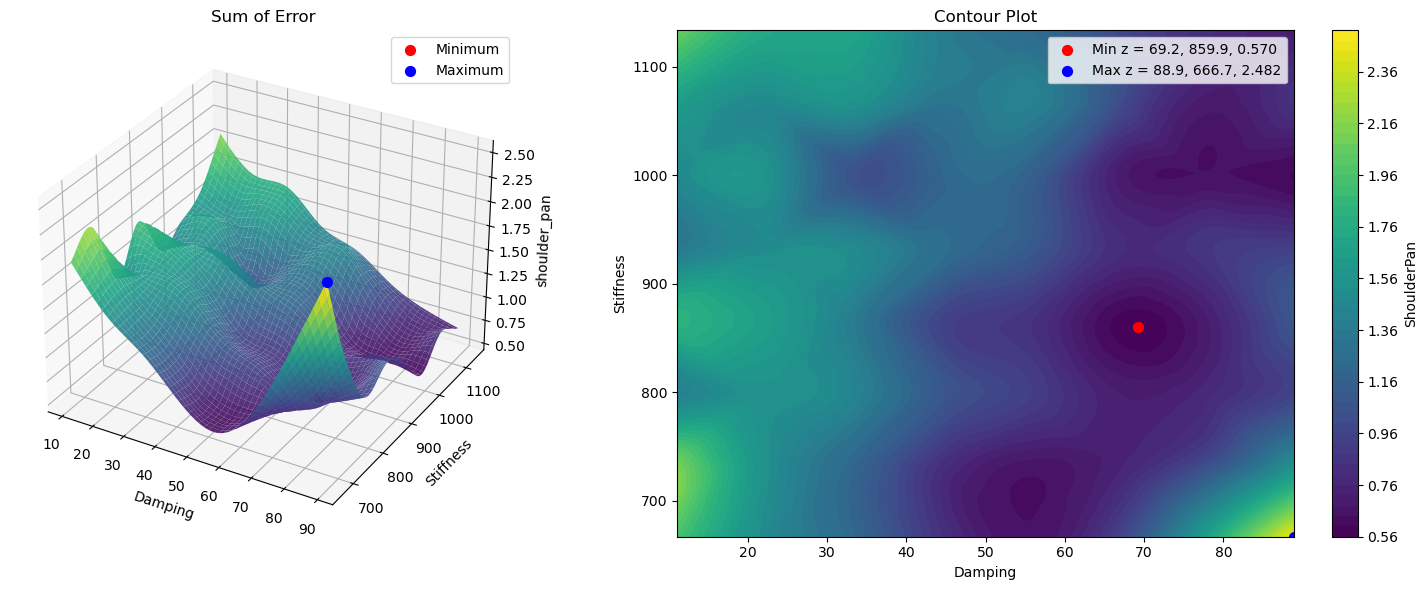

In [94]:
shoulder_pan_file = (
    "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_shoulder_pan_zz.csv"
)

draw(shoulder_pan_file, label="shoulder_pan")

# 2. Shoulder Lift Joint

/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Damping    Stiffness     Error       Sum
0   11.111111  1066.666626  0.115914  3.941091
1   33.333332   933.333313  0.110358  3.862527
2   11.111111   666.666687  0.105683  3.698902
3   22.222221  1000.000000  0.105667  3.804003
4   22.222221   733.333313  0.104704  3.664655
..        ...          ...       ...       ...
59  77.777779   800.000000  0.028851  0.980949
60  66.666664  1066.666626  0.028720  1.062650
61  88.888885   733.333313  0.027656  0.995599
62  66.666664   933.333313  0.027454  1.043263
63  88.888885   866.666687  0.022329  0.736858

[64 rows x 4 columns]

Max Error: 0.115914	 at Damping=11.11111068725586,	 Stiffness=1066.6666259765625
Min Error: 0.022329	 at Damping=88.88888549804688,	 Stiffness=866.6666870117188


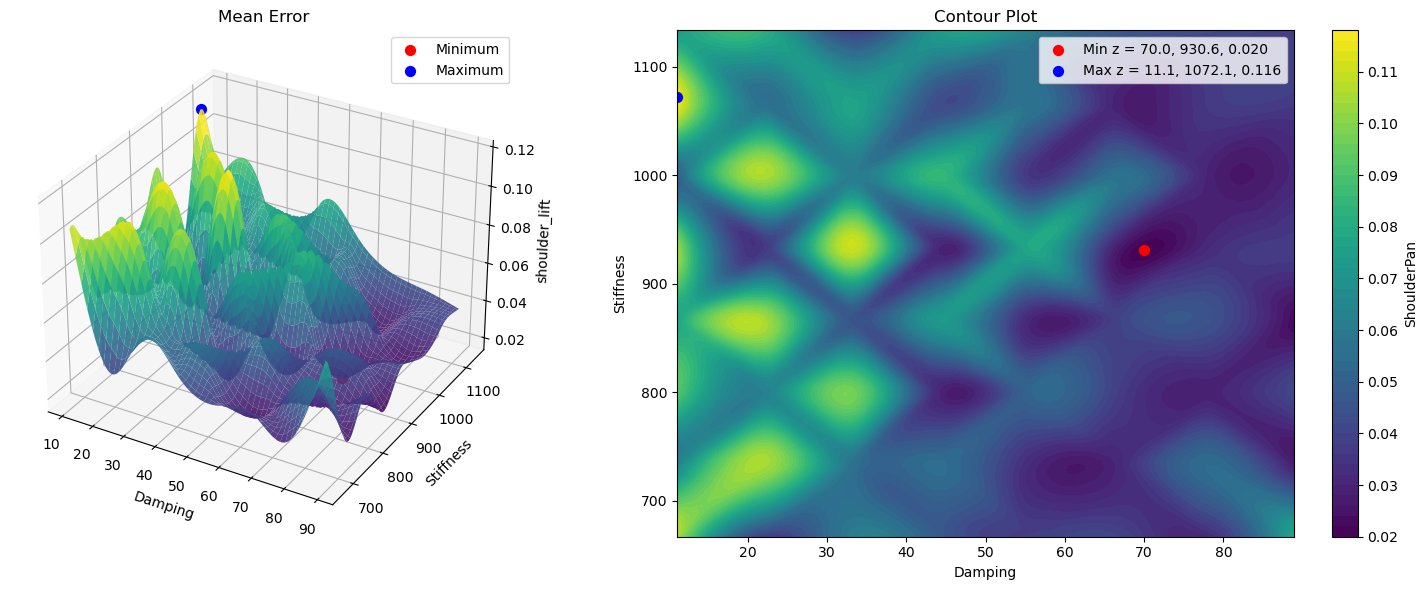

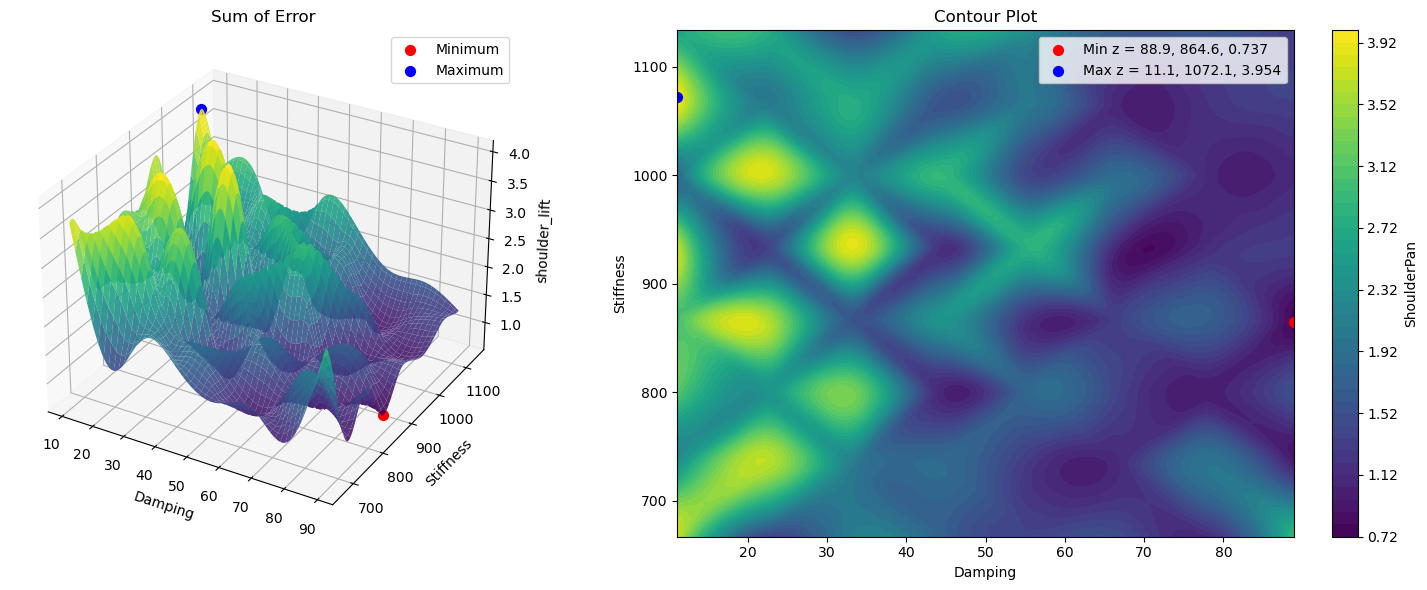

In [95]:
shoulder_lift_file = (
    "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_shoulder_lift_zz.csv"
)

draw(shoulder_lift_file, label="shoulder_lift")

# 3. Elbow Joint

/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Damping    Stiffness     Error       Sum
0   22.222221  1000.000000  0.064095  2.115135
1   11.111111  1133.333374  0.059156  2.011310
2   11.111111   866.666687  0.058513  1.989436
3   11.111111   733.333313  0.058427  1.986531
4   33.333332   866.666687  0.057899  1.968570
..        ...          ...       ...       ...
59  88.888885  1066.666626  0.021370  0.747967
60  88.888885  1133.333374  0.020741  0.705205
61  55.555557   733.333313  0.020318  0.690803
62  77.777779   933.333313  0.018759  0.656559
63  66.666664   800.000000  0.017814  0.623485

[64 rows x 4 columns]

Max Error: 0.064095	 at Damping=22.22222137451172,	 Stiffness=1000.0
Min Error: 0.017814	 at Damping=66.66666412353516,	 Stiffness=800.0


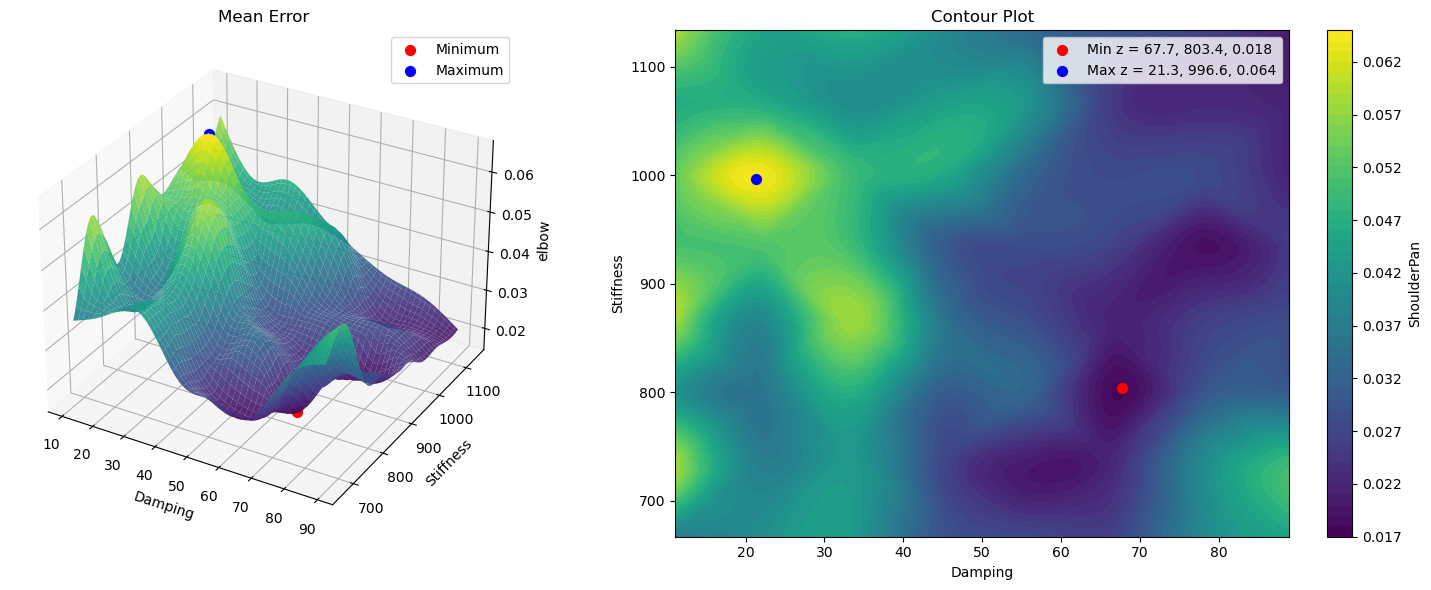

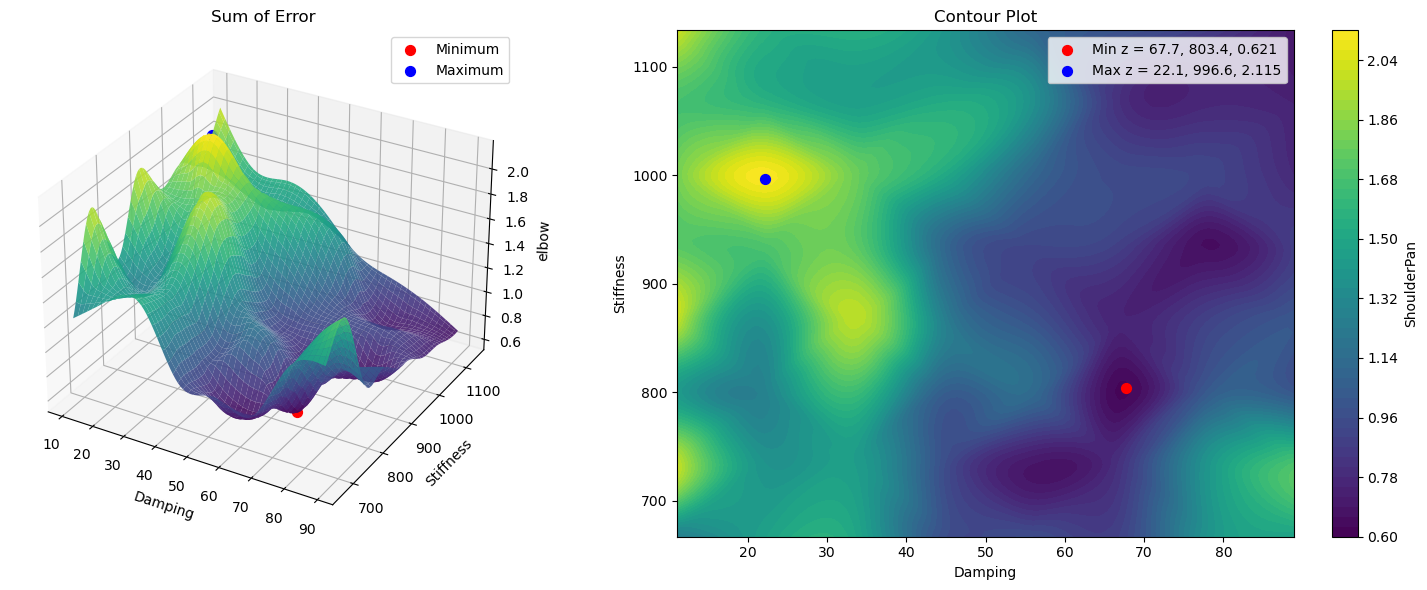

In [96]:
elbow_file = "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_elbow_zz.csv"

draw(elbow_file, label="elbow")

# Wrist1 Joint

/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Damping    Stiffness     Error       Sum
0   88.888885   666.666687  0.067046  2.413655
1   11.111111  1066.666626  0.057353  1.892652
2   33.333332  1066.666626  0.056156  2.077766
3   22.222221   866.666687  0.054053  1.891839
4   11.111111  1133.333374  0.052609  1.841325
..        ...          ...       ...       ...
59  77.777779  1066.666626  0.019577  0.665603
60  77.777779  1000.000000  0.019105  0.668663
61  55.555557   666.666687  0.017777  0.604421
62  66.666664   933.333313  0.017680  0.601122
63  66.666664   733.333313  0.015832  0.569964

[64 rows x 4 columns]

Max Error: 0.067046	 at Damping=88.88888549804688,	 Stiffness=666.6666870117188
Min Error: 0.015832	 at Damping=66.66666412353516,	 Stiffness=733.3333129882812


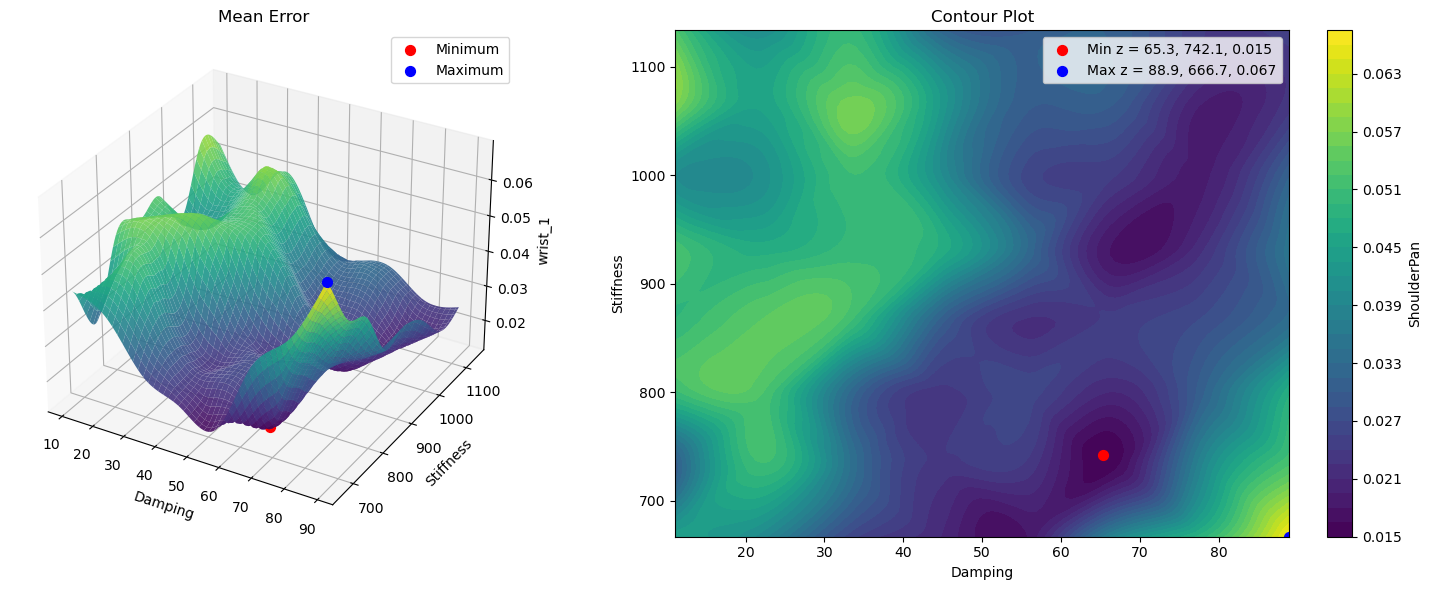

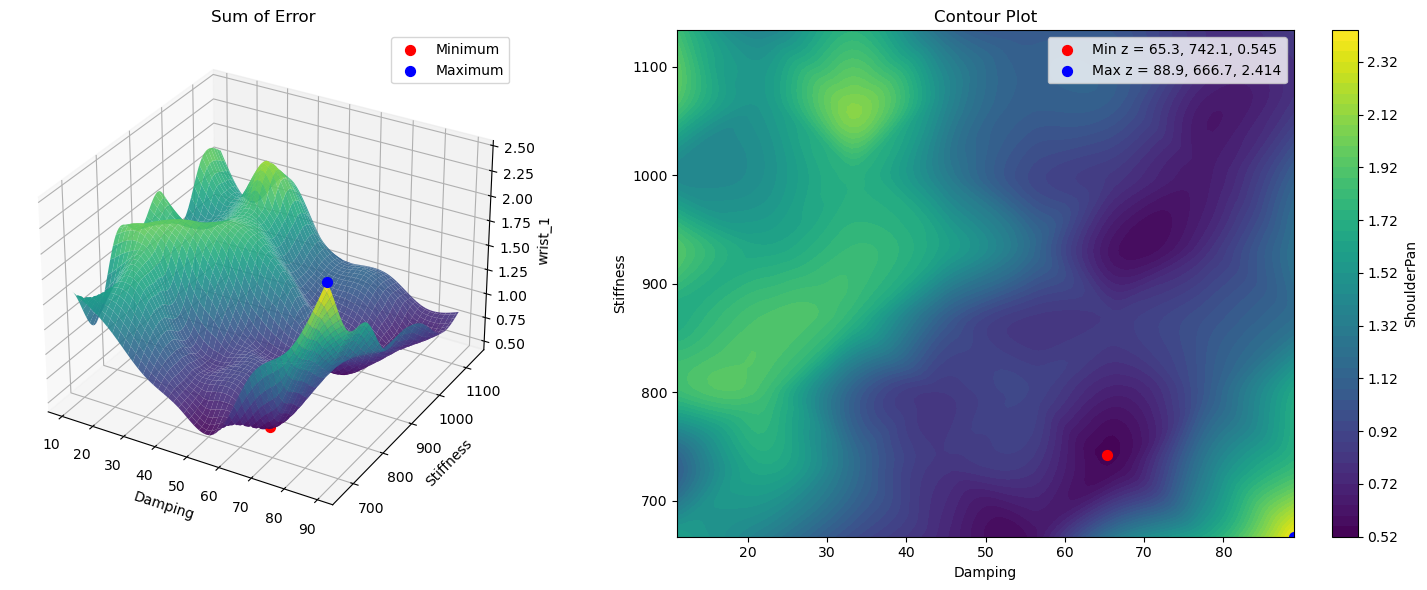

In [98]:
wrist1_file = (
    "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_wrist1_zz.csv"
)

draw(wrist1_file, label="wrist_1")

# Wrist2 Joint

/tmp/ipykernel_262882/1725569610.py:26: RuntimeWarning: Mean of empty slice.
  "Error": pos_error.mean(),
/home/min/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series

Damping    Stiffness     Error       Sum
0   88.888885   666.666687  0.071319  2.496157
1   11.111111   866.666687  0.058271  1.922951
2   11.111111  1133.333374  0.056652  1.982807
3   77.777779   666.666687  0.056170  1.853611
4   88.888885   733.333313  0.053093  1.964448
..        ...          ...       ...       ...
59  77.777779  1066.666626  0.021146  0.740121
60  88.888885  1133.333374  0.020254  0.708875
61  88.888885  1066.666626  0.019794  0.692786
62  44.444443   666.666687  0.019469  0.661962
63  55.555557   800.000000  0.018359  0.624205

[64 rows x 4 columns]

Max Error: 0.071319	 at Damping=88.88888549804688,	 Stiffness=666.6666870117188
Min Error: 0.018359	 at Damping=55.55555725097656,	 Stiffness=800.0


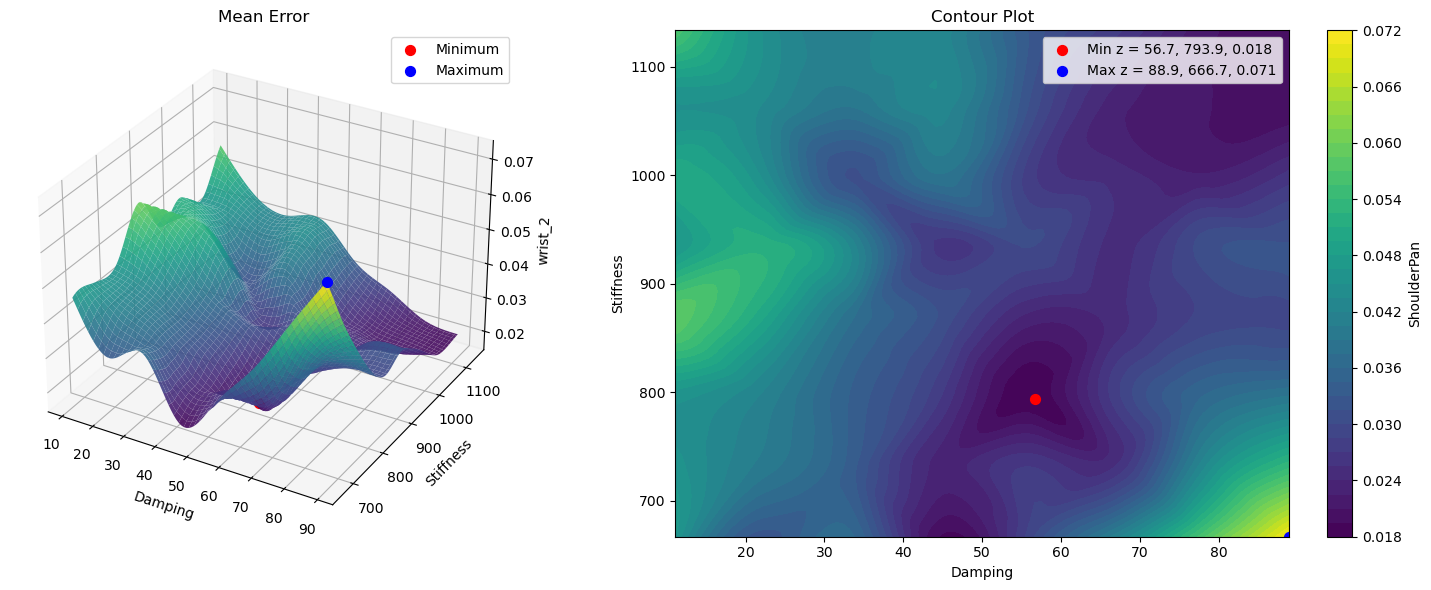

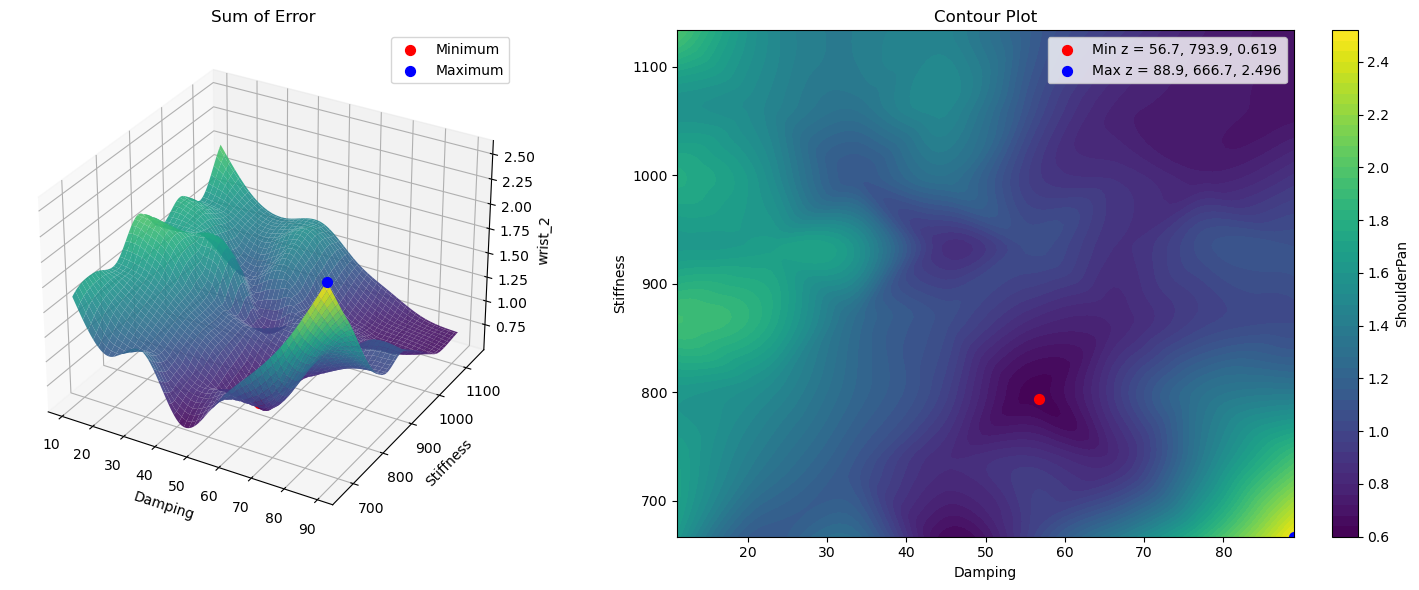

In [99]:
wrist2_file = (
    "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_wrist2_zz.csv"
)

draw(wrist2_file, label="wrist_2")

# Wrist3 Joint

/tmp/ipykernel_262882/1725569610.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Error"].fillna(df["Error"].mean(), inplace=True)
/tmp/ipykernel_262882/1725569610.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Damping    Stiffness     Error       Sum
0   88.888885   666.666687  0.069795  2.442828
1   88.888885   733.333313  0.068364  2.324370
2   77.777779   666.666687  0.061633  2.095521
3   77.777779   733.333313  0.054452  1.851373
4   88.888885   800.000000  0.051946  1.818103
..        ...          ...       ...       ...
59  66.666664   866.666687  0.024159  0.845551
60  77.777779  1133.333374  0.024057  0.793875
61  44.444443  1066.666626  0.023961  0.814685
62  77.777779  1000.000000  0.023664  0.804565
63  66.666664  1000.000000  0.022523  0.743260

[64 rows x 4 columns]

Max Error: 0.069795	 at Damping=88.88888549804688,	 Stiffness=666.6666870117188
Min Error: 0.022523	 at Damping=66.66666412353516,	 Stiffness=1000.0


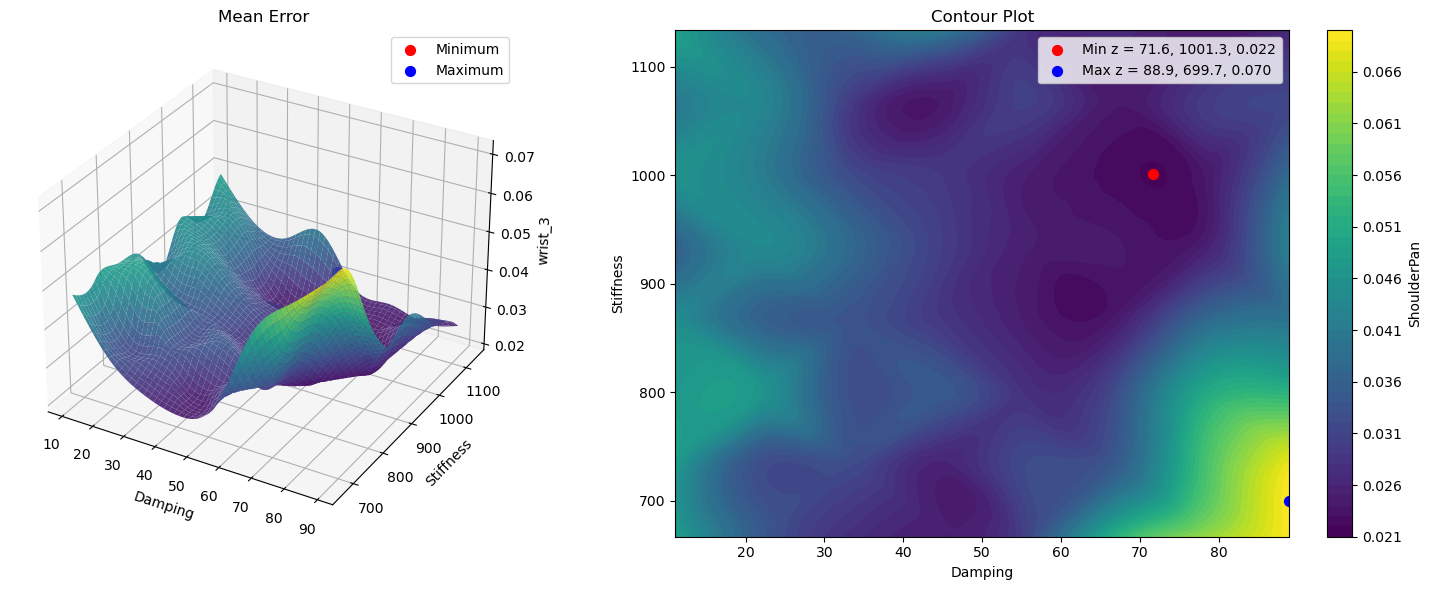

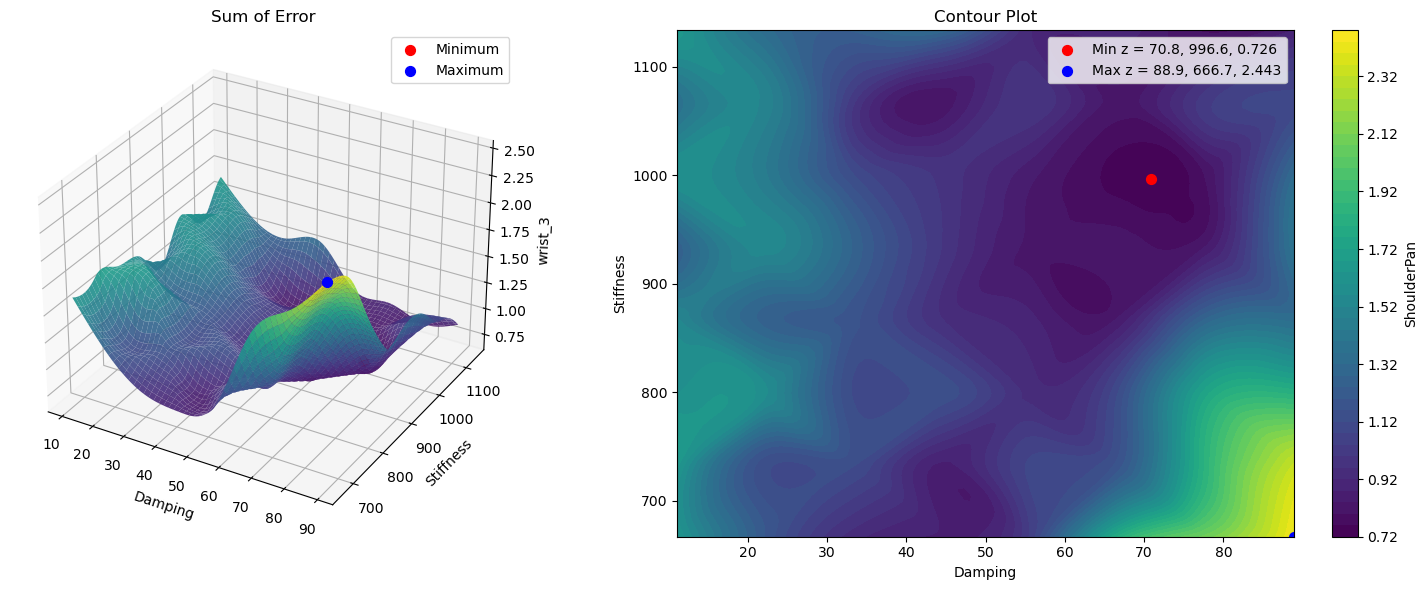

In [100]:
wrist3_file = (
    "/home/min/7cmdehdrb/project_th/tune/rtde_tune/data/rtde_log_wrist3_zz.csv"
)

draw(wrist3_file, label="wrist_3")